# Prediction of next day return of S&P500 futures based on historical prices using technical analysis and Machine Learning

## Project Overview:

The S&P500, which includes 500 of the largest companies listed on the stock market in the United States, represents a broad cross-section of the U.S. equity market. The primary aim of this project was to build a machine learning classifier capable of will tomorrow sesion will end with significant up or down. Importence of movement is based on historical daily returns.

**Why classification not regression?**

While it may seem like setting this up as a regression problem (predicting where the price will be) I recognized that, according to the random walk hypothesis, not every move is worth tracking. Therefore, I chose to classify them as either a significant decline (1) or a significant increase (2). On the other hand, everything in between is considered random walk (value 0) and not worth trading.


## Install yahoo finance and ta library

In [1]:
!pip install yahoo-finance
!pip install ta

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 4.1 MB/s eta 0:00:00
  Created wheel for yahoo-finance: filename=yahoo_finance-1.4.0-py3-none-any.whl size=7216 sha256=a02cee6ef997aeba42c04df9fd7d2890505f2b48fc2cf4aa137500ab1c769925
  Stored in directory: /root/.cache/pip/wheels/f6/a9/34/f1aaa343d0861148f79a9df08f380e4dbbdbe27b7ba1e0e84c
Successfully built yahoo-finance
  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29088 sha256=b97916ebb36036c034b30a88367feb77b5bb756d4556128d51edf3a1f4958d28
  Stored in directory: /root/.cache/pip/wheels/47/51/06/380dc516ea78621870b93ff65527c251afdfdc5fa9d7f4d248
Successfully built ta


## Imports

In [2]:
# Remove unwanted warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
#import libriaries
import yfinance as yf
import numpy as np
import pandas as pd
#scaler, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
# machine learning models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
#technical analysis
from ta import add_all_ta_features
#PCA
from sklearn.decomposition import PCA
# Statistics
from statsmodels.tsa.stattools import adfuller
# models validation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
#visualization
import matplotlib.pyplot as plt

## Download data from yahoo finance (yf)

In [3]:
sp = yf.Ticker("ES=F")
hist = sp.history(period='13y')
df=hist.drop(columns={'Dividends','Stock Splits'})
df=df.dropna()
df

,Open,High,Low,Close,Volume
Date,,,,,
2010-07-14 00:00:00-04:00,1095.00,1099.00,1083.50,1091.00,1940692
2010-07-15 00:00:00-04:00,1091.25,1099.25,1076.25,1090.50,2416608
2010-07-16 00:00:00-04:00,1090.50,1094.75,1059.00,1063.00,2503643
2010-07-19 00:00:00-04:00,1061.75,1071.00,1057.00,1063.75,1760879
2010-07-20 00:00:00-04:00,1063.25,1080.75,1050.75,1080.00,2275816
...,...,...,...,...,...
2023-07-10 00:00:00-04:00,4437.50,4448.25,4411.25,4444.25,1361155
2023-07-11 00:00:00-04:00,4445.75,4478.50,4439.00,4473.50,1340232
2023-07-12 00:00:00-04:00,4471.00,4523.75,4470.00,4507.50,1784296


Look at chart of Close price because based on it we will create return values

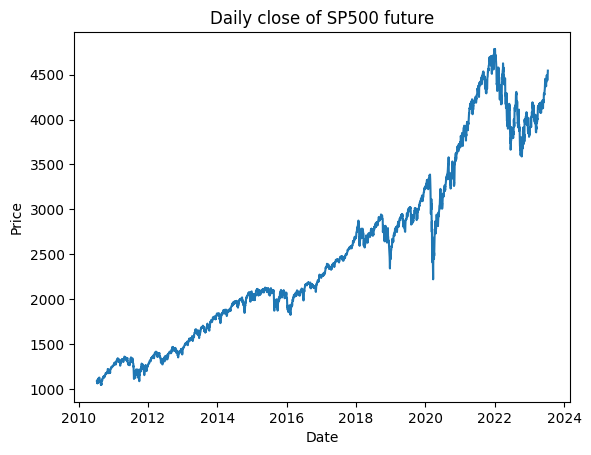

In [4]:
plt.plot(df.index,df['Close'])
plt.title('Daily close of SP500 future')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

Doesn't look like a stationary data. But look also at the histogram of these values.

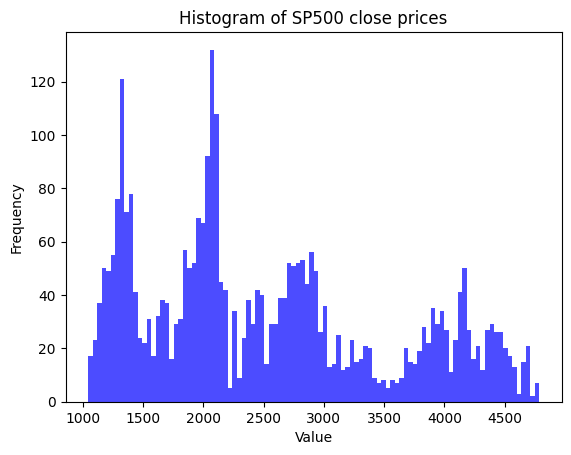

In [5]:
df['Close'].hist(bins=100, grid=False, color='blue', alpha=0.7)
plt.title('Histogram of SP500 close prices')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

Closing prices of S&P500 futures are definitely non-stationary data.

## Technical analysis

Technical analysis is a method people use to evaluate investments and identify trading opportunities by analyzing statistical trends gathered from trading activity, such as price movement and volume. Instead of looking at the company's details like its financial health or products, they look at charts of price movement and various analytical tools to evaluate a security's strength or weakness. It can be used also for indicies or currencies trading. One of the rules of technical analysis says that the price already contains everything (the hopes and fears of investors). So, theoretically, using technical analysis alone, it should be possible to predict the price.

In [6]:
#adding all technical features from ta library
df_ = add_all_ta_features(df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
# looking at new df
df_.head()

,Open,High,Low,Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2010-07-14 00:00:00-04:00,1095.00,1099.00,1083.50,1091.00,1940692,-6.260297e+04,1940692,-0.032258,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1091.000000,-56.758043,0.000000,0.000000
2010-07-15 00:00:00-04:00,1091.25,1099.25,1076.25,1090.50,2416608,5.152816e+05,-475916,0.118257,-1.208304e+06,-3331.115348,...,-0.003656,-0.000731,-0.002925,1.921349,0.384270,1.537080,1090.783781,-0.045830,-0.045840,-0.045830
2010-07-16 00:00:00-04:00,1090.50,1094.75,1059.00,1063.00,2503643,-1.428106e+06,-2979559,-0.208150,-1.087143e+07,-15528.621692,...,-0.207956,-0.042176,-0.165780,3.683295,1.044075,2.639220,1078.820055,-2.521779,-2.554121,-2.566453
2010-07-19 00:00:00-04:00,1061.75,1071.00,1057.00,1063.75,1760879,-1.490994e+06,-1218680,-0.172933,-9.129703e+06,-10236.364906,...,-0.360767,-0.105894,-0.254873,2.130378,1.261336,0.869043,1072.460995,0.070555,0.070530,-2.497709
2010-07-20 00:00:00-04:00,1063.25,1080.75,1050.75,1080.00,2275816,6.710310e+05,1057136,0.061576,-2.542315e+06,2306.864878,...,-0.357020,-0.156119,-0.200901,2.890009,1.587070,1.302939,1075.566724,1.527615,1.516064,-1.008249


## Features engineering

Some of the columns may be also considered as a non-stationary data. So let's find out how many are them using adfuller.

In [7]:
# Identify non-stationary columns
non_stationaries = []
for col in df_.columns:
    dftest = adfuller(df_[col].values)
    p_value = dftest[1]
    t_test = dftest[0] < dftest[4]["1%"]
    if p_value > 0.05 or not t_test:
        non_stationaries.append(col)
print(f"Non-Stationary Features Found: {len(non_stationaries)}")

Non-Stationary Features Found: 31


There is 91 features and 31 of them are non-stationary. Let's change them to stationary with .pct_change() method.

In [8]:
# Convert non-stationaries to stationary
df_stationary = df_.copy()
df_stationary[non_stationaries] = df_stationary[non_stationaries].pct_change()
# Lets start from second row, becouse first one is full of NaNs
df_stationary = df_stationary.iloc[1:]
# take a look at our data
df_stationary.head()

,Open,High,Low,Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2010-07-15 00:00:00-04:00,-0.003425,0.000227,-0.006691,-0.000458,2416608,-9.230945,-1.245230,0.118257,-1.208304e+06,-3331.115348,...,-0.003656,-0.000731,-0.002925,1.921349,0.384270,1.537080,-0.000198,-0.045830,-0.045840,-inf
2010-07-16 00:00:00-04:00,-0.000687,-0.004094,-0.016028,-0.025218,2503643,-3.771506,5.260683,-0.208150,-1.087143e+07,-15528.621692,...,-0.207956,-0.042176,-0.165780,3.683295,1.044075,2.639220,-0.010968,-2.521779,-2.554121,55.000000
2010-07-19 00:00:00-04:00,-0.026364,-0.021694,-0.001889,0.000706,1760879,0.044036,-0.590986,-0.172933,-9.129703e+06,-10236.364906,...,-0.360767,-0.105894,-0.254873,2.130378,1.261336,0.869043,-0.005894,0.070555,0.070530,-0.026786
2010-07-20 00:00:00-04:00,0.001413,0.009104,-0.005913,0.015276,2275816,-1.450056,-1.867443,0.061576,-2.542315e+06,2306.864878,...,-0.357020,-0.156119,-0.200901,2.890009,1.587070,1.302939,0.002896,1.527615,1.516064,-0.596330
2010-07-21 00:00:00-04:00,0.015283,0.006477,0.009755,-0.014815,2440958,-2.821708,-2.309029,-0.091646,-7.758460e+06,9451.975413,...,-0.468072,-0.218510,-0.249562,4.059310,2.081518,1.977792,-0.004456,-1.481481,-1.492565,1.454545


Some of these columns may have NaN values or infinity (inf/-inf). Let's clean our data set.

In [9]:
# Find NaN Rows
na_list = df_stationary.columns[df_stationary.isna().any().tolist()]
df_stationary.drop(columns=na_list, inplace=True)
# Handle inf values
df_stationary.replace([np.inf, -np.inf], 0, inplace=True)
df_stationary.head()

,Open,High,Low,Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2010-07-15 00:00:00-04:00,-0.003425,0.000227,-0.006691,-0.000458,2416608,-9.230945,-1.245230,0.118257,-1.208304e+06,-3331.115348,...,-0.003656,-0.000731,-0.002925,1.921349,0.384270,1.537080,-0.000198,-0.045830,-0.045840,0.000000
2010-07-16 00:00:00-04:00,-0.000687,-0.004094,-0.016028,-0.025218,2503643,-3.771506,5.260683,-0.208150,-1.087143e+07,-15528.621692,...,-0.207956,-0.042176,-0.165780,3.683295,1.044075,2.639220,-0.010968,-2.521779,-2.554121,55.000000
2010-07-19 00:00:00-04:00,-0.026364,-0.021694,-0.001889,0.000706,1760879,0.044036,-0.590986,-0.172933,-9.129703e+06,-10236.364906,...,-0.360767,-0.105894,-0.254873,2.130378,1.261336,0.869043,-0.005894,0.070555,0.070530,-0.026786
2010-07-20 00:00:00-04:00,0.001413,0.009104,-0.005913,0.015276,2275816,-1.450056,-1.867443,0.061576,-2.542315e+06,2306.864878,...,-0.357020,-0.156119,-0.200901,2.890009,1.587070,1.302939,0.002896,1.527615,1.516064,-0.596330
2010-07-21 00:00:00-04:00,0.015283,0.006477,0.009755,-0.014815,2440958,-2.821708,-2.309029,-0.091646,-7.758460e+06,9451.975413,...,-0.468072,-0.218510,-0.249562,4.059310,2.081518,1.977792,-0.004456,-1.481481,-1.492565,1.454545


Now when data are stationary and 'Close' is actually return values -  let's check how it looks

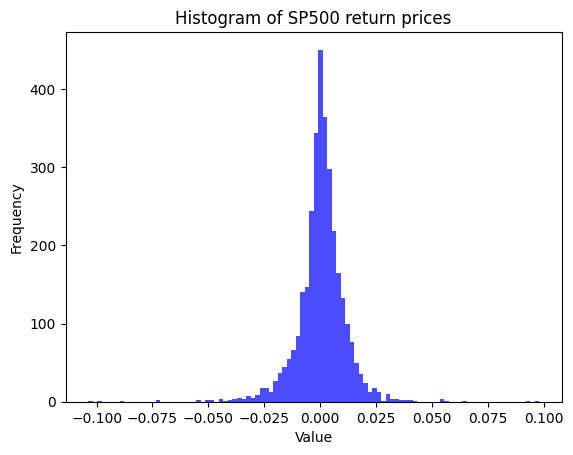

In [10]:
df_stationary['Close'].hist(bins=100, grid=False, color='blue', alpha=0.7)
plt.title('Histogram of SP500 return prices')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

 Now set our targets

In [11]:
first_quantile = df_stationary['Close'].quantile(0.25) # significant down move
last_quantile = df_stationary['Close'].quantile(0.75) # significant upper move

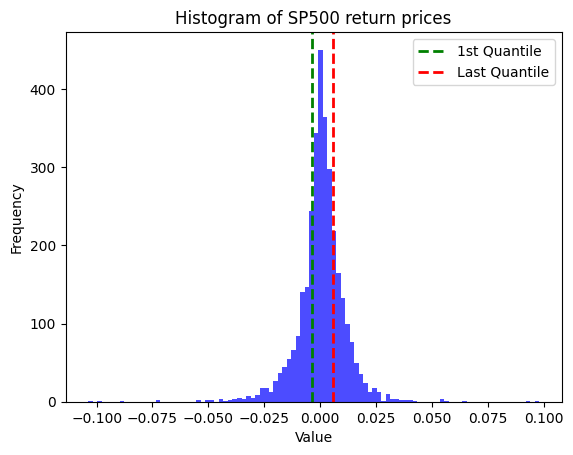

In [12]:
df_stationary['Close'].hist(bins=100, grid=False, color='blue', alpha=0.7)
plt.axvline(first_quantile, color='green', linestyle='dashed', linewidth=2, label='1st Quantile')
plt.axvline(last_quantile, color='red', linestyle='dashed', linewidth=2, label='Last Quantile')
plt.title('Histogram of SP500 return prices')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Everything from green line to left, and from red line to right is considered to be significant movement.

## Setting targets

In [13]:
#creating target column
# (0 -> no deal)
# (1-> short)
# (2 -> long)

df_stationary['Target'] = np.where(df_stationary['Close'] <= first_quantile, 1,
                        np.where(df_stationary['Close'] >= last_quantile, 2, 0))
#target is based on next day value, so we need to shift it
df_stationary['Target'] = df_stationary['Target'].shift(-1)
# dropping NaN from the entire DataFrame
df_stationary.dropna(inplace=True) # droping NaN

The closing price is the last price of the day (session). This means that for instruments for which the session has not ended, the price will be determined based on the last price. Since it will be possible to determine the rate of return only after the end of the day, the last row of test data should be removed, since the prediction is created on the basis of the "virtual closing price"

In [14]:
#droping last row of test set
df_stationary.drop(df_stationary.tail(1).index,inplace = True)

## Split data to train and test

In [15]:
# first 80% of df is training set -> rest of it will be test set
train_set, test_set= np.split(df_stationary, [int(0.80 *len(df_stationary))])

X_train = train_set.drop(columns={'Target'})
y_train = train_set['Target']

X_test = test_set.drop(columns={'Target'})
y_test = test_set['Target']

## PCA Dimensionality Reduction

There are 93 columns (quite a lot). I want to reduce them by using unsupervised ML method - PCA

In [16]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA on the scaled features
pca = PCA(0.9) # I want to find 90% of variance, and I don't know how many components it will need
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

## Find best hyperparameters with XGB Classifier and GridSearch

In [18]:
xgb = XGBClassifier(verbosity=0,num_class=3)
# define parameter grid
param_grid = {
    'objective':['multi:softprob','multi:softmax'],
    'learning_rate': [0.005, 0.01, 0.1, 0.2, 0.3, 0.5],
    'max_depth': [1,2,3,5,6],
    'n_estimators': [50, 100, 200, 300],
    'tree_method':['gpu_hist'],
    'scoring' : ['f1_score'],
}
# create xgb
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3)

# # fit model
grid_search.fit(X_train_pca, y_train)



GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, num_class=3,
                                     num_parallel_tree=None, predictor=None, ...),
             param_grid={'learning_rate': [0.005, 0.01, 0.1, 0.2, 0.3, 0.5],
                         'max_depth': [1, 2, 3, 5, 6],
                         'n_estimators': [50, 100, 200, 300],
                         'objective': ['multi:softprob', 'multi:softmax'],
                         'scoring': ['f1_score'], 'tree_method': ['gpu_hist']})

In [19]:
# get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

Best parameters: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 200, 'objective': 'multi:softprob', 'scoring': 'f1_score', 'tree_method': 'gpu_hist'}


In [20]:
# get the best score
best_score = grid_search.best_score_
print(f"Best score: {best_score}")

Best score: 0.5424311926605504


In [21]:
y_pred_grid = grid_search.predict(X_test_pca)

In [22]:
def print_metrics(y_true, y_pred, classifier_name):
    print(classifier_name)
    print("Precision:", precision_score(y_true, y_pred_grid,average='weighted'))
    print("Recall:", recall_score(y_true, y_pred_grid,average='weighted'))
    print("F1-score:", f1_score(y_true, y_pred_grid,average='weighted'))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred_grid))

In [23]:
print_metrics(y_test, y_pred_grid, "XGB Classifier")

XGB Classifier
Precision: 0.4744102123589734
Recall: 0.44122137404580153
F1-score: 0.3809839809066554
Confusion Matrix:
 [[200   6  55]
 [117  14  70]
 [114   4  75]]


Looking at confusion matrix I can say, that model is good in predicting when to not to trade. Which can be helpful, but goal is to properly predict when to sell or buy. There is why I'm going to try another model - random forest

## Random Forest

In [24]:
from sklearn.metrics import make_scorer, recall_score

# Define the parameter grid
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Create a base model
rf = RandomForestClassifier()

# Define the scoring methods for the GridSearch
scoring = {'Precision': make_scorer(precision_score, average = 'macro'),
           'Recall': make_scorer(recall_score, average = 'macro'),
           'F1_Score': make_scorer(f1_score, average = 'macro')}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                           cv = 3, n_jobs = -1, verbose = 2, scoring=scoring,
                           refit='F1_Score')

# Fit the grid search to the data
grid_search.fit(X_train_pca, y_train)

# Print out the best parameters
print(grid_search.best_params_)


Fitting 3 folds for each of 648 candidates, totalling 1944 fits
{'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 10}


In [27]:
y_pred_grid = grid_search.predict(X_test_pca)

In [28]:
print_metrics(y_test, y_pred_grid, "Random Forest")

Random Forest
Precision: 0.3711556114993388
Recall: 0.3786259541984733
F1-score: 0.3706802037369901
Confusion Matrix:
 [[141  43  77]
 [ 81  46  74]
 [ 82  50  61]]


It's not even close to predicting significant movement up or down.

## Conclusion

Assuming that all the data is already in the price and with the help of technical analysis alone you can predict significant movements of asset is wrong. There are a number of factors influencing investors behavior that go beyond historical movements.

Of course, the project does not exclude the possibility of effective use of this type of analysis. A considerable limitation, and the disadvantage of the approach used, was the setting of the target as a significant upward or downward movement of the next day.

It is possible that a study focused on whether there would be a significant movement within 'x' days could have proved much more accurate. Nevertheless, in such a case there would have been a risk of adjusting the approach to suit the expected result, which is a crucial mistake.